In [1]:
import os, sys
import numpy as np
from numpy.random import multinomial
import EMdata
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
import itertools
import random, math
from collections import Counter
import matplotlib
import matplotlib.pyplot as plt
import time

In [2]:
#GPU or CPU
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  
device = torch.device(dev) 

In [5]:
#data path
file_path='F:/script/class2vec/real_star_file/10340_Reja_320.star'
datatype=1 #0 is relion 3.1, 1 is relion 3, 2 is cryosparc

file_name=os.path.basename(file_path)
output_path=os.path.dirname(file_path)+'/'+os.path.splitext(file_name)[0]
if os.path.isdir(output_path) is False:
    os.mkdir(output_path)

In [6]:
if datatype<2:
    file_info=EMdata.read_relion(file_path)
    if datatype==0:
        #read data (relion3.1)
        dataset=file_info.getRdata_31()
        optics=file_info.extractoptic()
    else:
        #read relion 3.0
        dataset=file_info.getRdata()
    metadata=dataset[0]
    print(metadata)
    data=dataset[1]
    print(data[0])
    corpus_information=EMdata.process_helical(dataset).extarct_helical_select()
else:
    #read cryosparc
    dataset=np.load(file_path)
    corpus_information=EMdata.process_cryosparc_helical(dataset).extract_helical()
corpus_dic=corpus_information[0]
corpus=list(corpus_dic.values())
corpus_backup=corpus[:]

['_rlnCoordinateX', '_rlnCoordinateY', '_rlnHelicalTubeID', '_rlnAngleTiltPrior', '_rlnAnglePsiPrior', '_rlnHelicalTrackLengthAngst', '_rlnAnglePsiFlipRatio', '_rlnAngleRotFlipRatio', '_rlnImageName', '_rlnMicrographName', '_rlnOpticsGroup', '_rlnCtfMaxResolution', '_rlnCtfFigureOfMerit', '_rlnDefocusU', '_rlnDefocusV', '_rlnDefocusAngle', '_rlnCtfBfactor', '_rlnCtfScalefactor', '_rlnPhaseShift', '_rlnGroupNumber', '_rlnAngleRot', '_rlnAngleTilt', '_rlnAnglePsi', '_rlnOriginXAngst', '_rlnOriginYAngst', '_rlnClassNumber', '_rlnNormCorrection', '_rlnLogLikeliContribution', '_rlnMaxValueProbDistribution', '_rlnNrOfSignificantSamples']
['1365.689787', '169.791979', '1', '90.000000', '-53.25944', '164.499993', '0.500000', '0.500000', '000001@Extract/job040/Micrographs/FoilHole_21756216_Data_21768957_21768958_20181221_2054-115048.mrcs', 'Micrographs/FoilHole_21756216_Data_21768957_21768958_20181221_2054-115048.mrc', '1', '4.124138', '0.074823', '19105.767578', '17957.419922', '14.688353', '0

In [7]:
corpus_ignore=[]
for i in range(len(corpus)):
    corpus_row=[]
    count=1
    lst=corpus[i]
    for j in range(len(lst)):
        particle=lst[j]
        if j==0:
            count+=particle[1]-1
        if count==int(particle[1]):
            corpus_row.append(str(particle[0]))
            count+=1
        else:
            while 1:
                if count==int(lst[j][1]):
                    corpus_row.append(str(particle[0]))
                    count+=1
                    break
                corpus_row+=['0']
                count+=1               
    corpus_ignore.append(corpus_row)

176


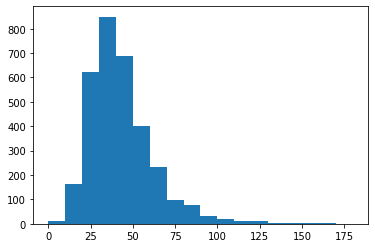

In [8]:
corpus_length_histogram=[]
for i in range(len(corpus_ignore)):
    corpus_length_histogram.append(len(corpus_ignore[i]))
plt.hist(corpus_length_histogram,list(range(0,max(corpus_length_histogram)+10,10)))
print(max(corpus_length_histogram))
plt.show()

In [9]:
vocabulary = set(itertools.chain.from_iterable(corpus_ignore))
vocabulary_size = len(vocabulary)
print(vocabulary_size)

48


In [10]:
word_to_index = {w: idx for (idx, w) in enumerate(vocabulary)}
index_to_word = {idx: w for (idx, w) in enumerate(vocabulary)}

In [11]:
from pathlib import Path

from tokenizers import ByteLevelBPETokenizer
if os.path.isdir(output_path+"/corpus") is False:
    os.mkdir(output_path+"/corpus")
paths = [str(x) for x in Path(output_path+"/corpus/").glob("**/*.txt")]

# Initialize a tokenizer
tokenizer = ByteLevelBPETokenizer()

# Customize training
tokenizer.train(files=paths, vocab_size=vocabulary_size, min_frequency=2, special_tokens=[
    "<s>",
    "<pad>",
    "</s>",
    "<unk>",
    "<mask>",
])
if os.path.isdir(output_path+"/tokens") is False:
    os.mkdir(output_path+"/tokens")
tokenizer.save_model(output_path+"/tokens")

['F:/script/class2vec/real_star_file/10340_Reja_320/tokens\\vocab.json',
 'F:/script/class2vec/real_star_file/10340_Reja_320/tokens\\merges.txt']

In [12]:
import json

with open(output_path+'/tokens/vocab.json') as f:
    decode = json.load(f)

In [13]:
encode={value:key for (key, value) in decode.items()}

In [14]:
corpus_code=[]
for i in range(len(corpus_ignore)):
    lst=corpus_ignore[i]
    corpus_row=[]
    for j in range(len(lst)):
        corpus_row.append(encode[word_to_index[lst[j]]+5])
    corpus_code.append(corpus_row)

In [15]:
with open(output_path+"/corpus/helical.txt","w") as f:
    for i in range(len(corpus_code)):
        lst=corpus_code[i]
        for j in range(len(lst)):
            if j==len(lst)-1:
                f.write(lst[j]+'\n')
            else:
                f.write(lst[j])

In [16]:
from transformers import RobertaTokenizerFast

tokenizer = RobertaTokenizerFast.from_pretrained(output_path+"/tokens", max_len=514)

In [17]:
tokenizer.encode(encode[word_to_index['50']+5])

[0, 25, 2]

In [18]:
from transformers import RobertaConfig

config = RobertaConfig(
    vocab_size=50_000,
    max_position_embeddings=128,
    num_attention_heads=12,
    num_hidden_layers=6,
    type_vocab_size=1,
)

In [19]:
from transformers import RobertaForMaskedLM

model = RobertaForMaskedLM(config=config)

In [20]:
%%time
from transformers import LineByLineTextDataset

data_import = LineByLineTextDataset(
    tokenizer=tokenizer,
    file_path=output_path+"/corpus/helical.txt",
    block_size=64,
)

Wall time: 74 ms


In [21]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=True, mlm_probability=0.15
)

In [22]:
print(data_import[0])

tensor([ 0, 40, 15, 40, 40, 15, 40, 15, 49, 46, 40,  8,  8, 15,  8,  8,  8,  8,
         8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
         8,  8, 45,  8,  8,  8,  8,  8, 46,  8,  8, 15, 18, 46, 42, 40, 46, 18,
        40, 18, 18, 15, 49, 42,  2])


In [23]:
from transformers import Trainer, TrainingArguments


trainer = Trainer(
    model=model,
    data_collator=data_collator,
    train_dataset=data_import,
    prediction_loss_only=True,
)

D:\ProgramData\Anaconda3\lib\site-packages\transformers\trainer.py:247: FutureWarning: Passing `prediction_loss_only` as a keyword argument is deprecated and won't be possible in a future version. Use `args.prediction_loss_only` instead.
  FutureWarning,


In [24]:
trainer.train()

{'loss': 1.8606002197265625, 'learning_rate': 2.9423868312757202e-05, 'epoch': 1.2345679012345678, 'step': 500}


D:\ProgramData\Anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


{'loss': 1.3450169677734376, 'learning_rate': 8.847736625514404e-06, 'epoch': 2.4691358024691357, 'step': 1000}




TrainOutput(global_step=1215, training_loss=1.5513653790509259)

In [25]:
trainer.save_model(output_path+"/tokens/")

In [27]:
from transformers import pipeline

feature_extraction = pipeline(
    'feature-extraction',model="./tokens",tokenizer="./tokens")

In [28]:
print(np.shape(feature_extraction(encode[word_to_index['50']+5])))

(1, 3, 768)


In [29]:
print(np.squeeze(feature_extraction('DGG'))[0]-np.squeeze(feature_extraction('JJ'))[0])

[-1.80430233e-01 -3.55516195e-01  4.45037246e-01 -1.67767689e+00
  5.42502657e-01 -5.72651744e-01  2.83637166e-01  8.00458260e-01
  9.80835587e-01 -3.65909085e-01 -6.02833271e-01 -3.75075370e-01
  1.94160153e+00  9.09421384e-01  1.07799590e+00  7.13159084e-01
  1.24155085e+00 -1.06261605e+00  4.48229253e-01  6.54031634e-02
  1.34683722e+00 -4.36475277e-01 -4.46113408e-01  9.98661041e-01
 -1.52422148e+00 -6.97560191e-01  4.37036991e-01 -4.50415649e-01
  7.18843043e-02  9.10529077e-01 -7.15424895e-01 -1.35681397e+00
 -2.00737326e+00  1.00310874e+00  8.03997621e-01  7.67339354e-01
 -9.50729370e-01 -6.89195395e-01 -3.26305628e-03  1.75659586e-01
  5.14471531e-03 -1.31114334e-01  8.65952760e-01  2.63053864e-01
 -4.68338013e-01  6.25206474e-02  7.72870498e-01 -9.70651180e-01
  6.23257160e-01 -5.24539948e-02  9.23735499e-02 -3.30797076e-01
 -1.13779545e-01  1.25030862e+00  1.05489165e+00 -5.36084175e-03
 -9.47813094e-02  2.14107037e-02 -1.30022758e+00 -2.25527471e+00
 -5.58688760e-01  1.50212

  3.63316327e-01 -1.78897016e-01  4.29383159e-01 -6.41985863e-01]


In [30]:
print(''.join(corpus_code[0]))

D+DD+D+MJD$$+$$$$$$$$$$$$$$$$$$$$$$$$I$$$$$J$$+.JFDJ.D..+MF


In [31]:
def cut_corpus(corpus,cut_length):
    new_corpus=[]
    cut_length=cut_length
    print(len(corpus))
    for i in range(len(corpus)):
        lst=corpus[i]
        n=len(lst)
        if n<cut_length:
            new_corpus.append(lst)
            continue
        cut_amount=int((n-n%cut_length)/cut_length)+1
        for j in range(cut_amount-1):
            new_corpus.append(lst[j*cut_length:(j+1)*cut_length])
        new_corpus.append(lst[(cut_amount-1)*cut_length:])
    print(len(new_corpus))
    return new_corpus
corpus_code_cut=cut_corpus(corpus_code,64)

3233
3635


In [32]:
filament_embeddings=[]
for i in range(len(corpus_code_cut)):
    if i%200==0:
        print(i)
    lst=list(np.squeeze(feature_extraction(''.join(corpus_code_cut[i])))[0])
    filament_embeddings.append(lst)

0
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600


In [33]:
len(''.join(corpus_code_cut[77]))

36

In [34]:
import umap
import sklearn
from sklearn.cluster import KMeans,SpectralClustering,MeanShift, estimate_bandwidth,AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from scipy.spatial.distance import cdist
from scipy.stats import multivariate_normal 
from sklearn.decomposition import PCA
import matplotlib.patches as mpatches

In [35]:
filament_embeddings=np.array(filament_embeddings)
mask_1 = np.isfinite(filament_embeddings).all(axis=1)

In [36]:
filament_embeddings[mask_1]

array([[-0.60308975,  1.18274534,  1.24558401, ...,  0.07562667,
         1.94138885,  0.20330903],
       [-0.22459114,  1.37867403,  0.09105249, ...,  0.07599733,
         1.83752978,  0.82710665],
       [-0.32058015,  1.28555799,  0.01569274, ..., -0.0193642 ,
         1.80236185,  0.60261649],
       ...,
       [-0.75131106,  0.49429709,  2.13530755, ...,  0.02157623,
         1.9515624 , -0.80261576],
       [-0.00819311,  0.50048208,  1.03153551, ...,  0.03696239,
         1.76706314, -0.86387986],
       [ 0.12728333,  0.26036328,  0.40052333, ...,  0.03178624,
         1.63811231, -0.80590689]])

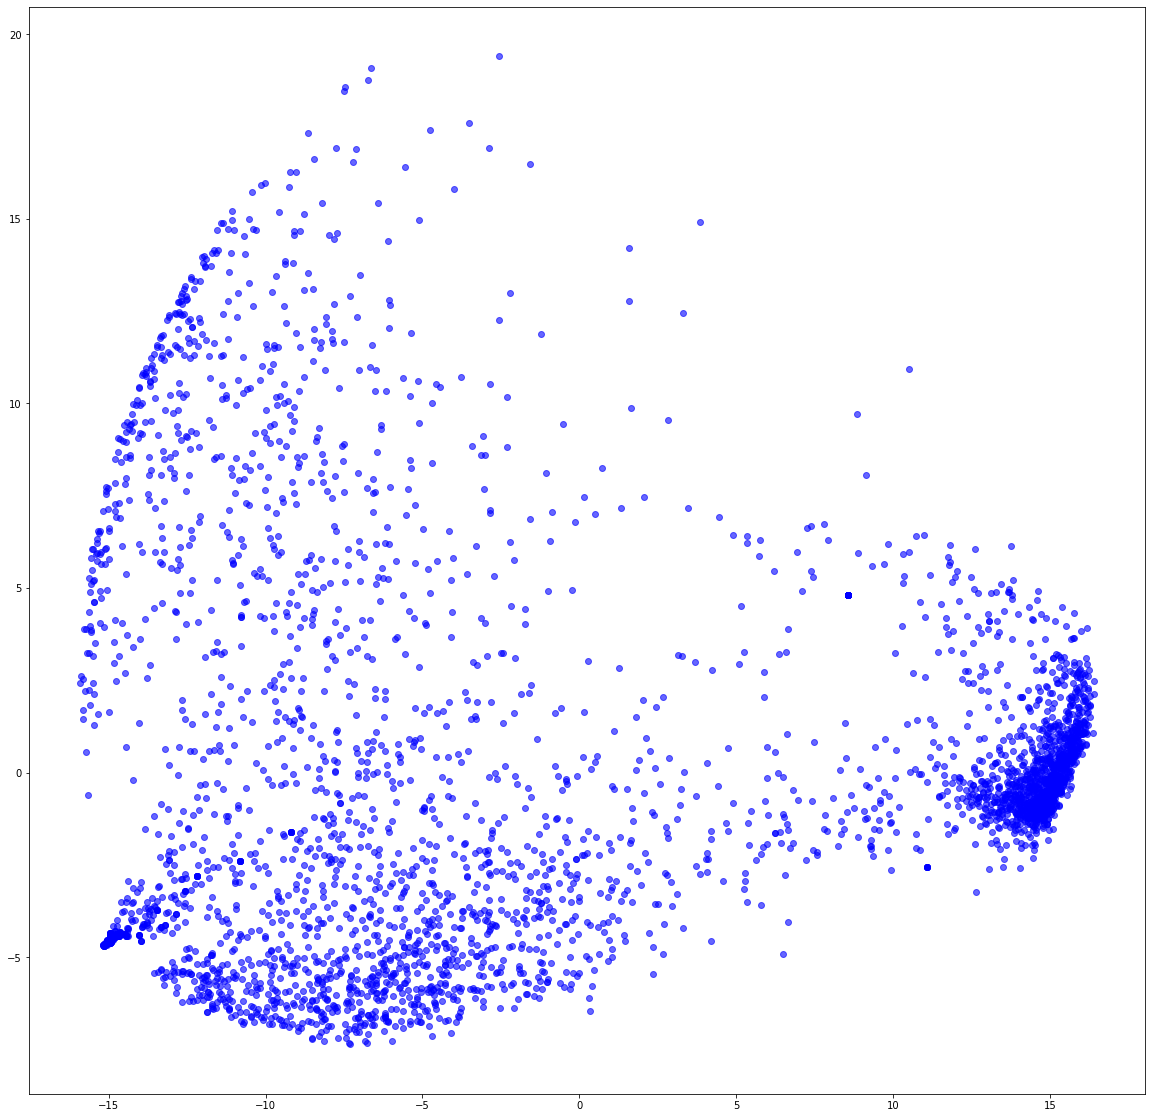

In [38]:
pca_sum = PCA(n_components=2).fit_transform(filament_embeddings)
#cluster_pca = KMeans(n_clusters=3).fit_predict(pca_sum[0:len(corpus)])
pca_sum_hD = PCA(n_components=30).fit_transform(filament_embeddings)

plt.figure(figsize = (20, 20))
plt.scatter(pca_sum[:,0], pca_sum[:,1],alpha=0.6,color='blue')
plt.savefig(output_path+'/'+os.path.splitext(file_name)[0]+"_pca_bert.png",bbox_inches='tight', pad_inches=0.01)
plt.show()

In [39]:
n_neighbors=100
min_dist=0.05
reducer = umap.UMAP(n_neighbors=n_neighbors,min_dist=min_dist)
umap_2D = reducer.fit_transform(filament_embeddings)

D:\ProgramData\Anaconda3\lib\site-packages\numba\np\ufunc\parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 11000. The TBB threading layer is disabled.
  warnings.warn(problem)


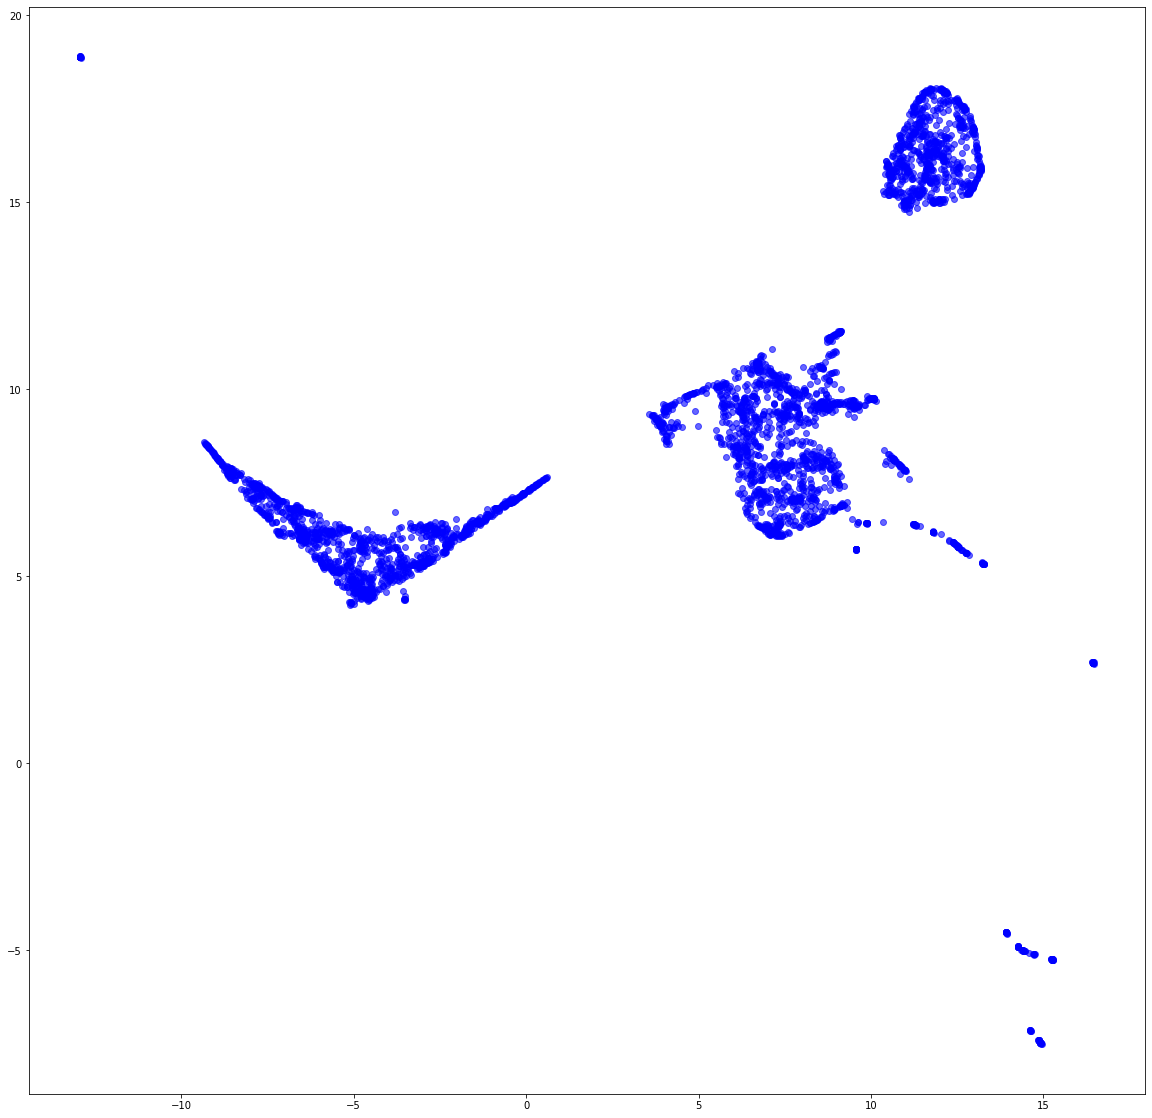

In [41]:
plt.figure(figsize = (20, 20))
plt.scatter(umap_2D[:,0], umap_2D[:,1],alpha=0.6,color='blue')
#plt.xlim(-6,15)
#plt.ylim(0,15)
plt.savefig(output_path+'/'+os.path.splitext(file_name)[0]+"_umap_bert.png",bbox_inches='tight', pad_inches=0.01)

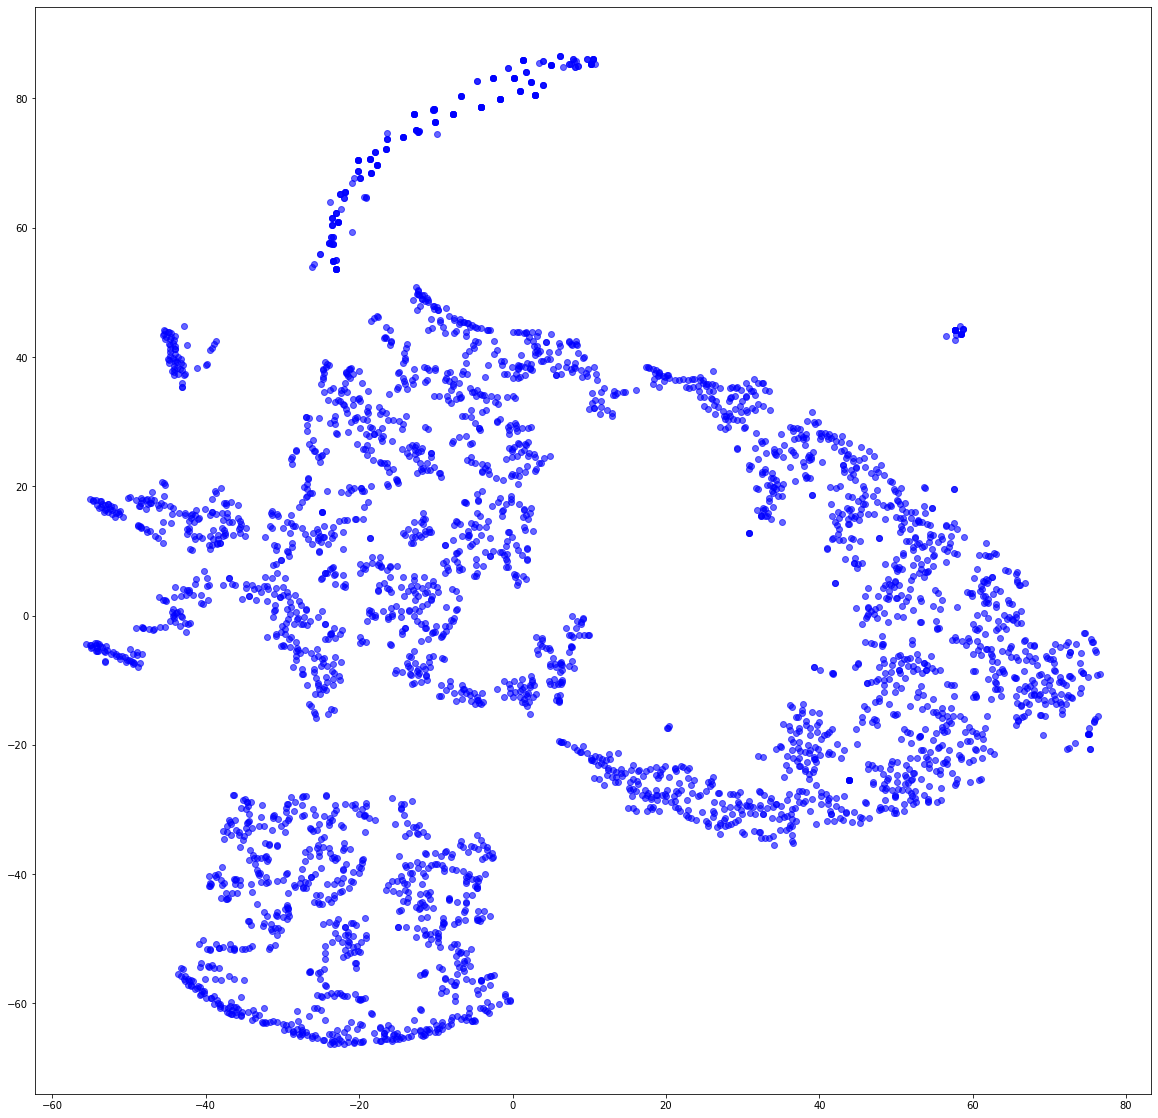

In [42]:
from sklearn.manifold import TSNE
tsne_data = TSNE(n_components=2).fit_transform(filament_embeddings)
#cluster_pca = KMeans(n_clusters=3).fit_predict(pca_sum[0:len(corpus)])

plt.figure(figsize = (20, 20))
plt.scatter(tsne_data[:,0], tsne_data[:,1],alpha=0.6,color='blue')
#plt.savefig(output_path+'/'+os.path.splitext(file_name)[0]+"_pca_bert.png",bbox_inches='tight', pad_inches=0.01)
plt.show()

In [ ]:
count=0
labels=['127','128']
labels_name=['singlet','doublet']
positive_label=[]
x=0
for i in range(len(corpus_code_cut)):
    lst=corpus_code_cut[i]
    x=x+len(lst)
    positive_label.append(data[x-1][7][18:21])
print(x)
print(len(data))
positive_label_new=np.array([float(labels.index(x)) for x in positive_label])

In [ ]:
plt.figure(figsize = (20, 20))
for i in range(len(labels_name)):
    locals()['true_label'+str(i)]=mpatches.Patch(color=plt.cm.tab20(i/4), label=labels_name[i])
plt.legend(handles=[eval('true_label'+str(i)) for i in range(len(labels))])
print(len(positive_label))
plt.xlim(5,15)
plt.scatter(umap_2D[:,0], umap_2D[:,1],color=plt.cm.tab20(positive_label_new/4),alpha=0.6)

In [ ]:
plt.figure(figsize = (20, 20))
for i in range(len(labels_name)):
    locals()['true_label'+str(i)]=mpatches.Patch(color=plt.cm.tab20(i/4), label=labels_name[i])
plt.legend(handles=[eval('true_label'+str(i)) for i in range(len(labels))])
print(len(positive_label))
plt.xlim(5,15)
plt.scatter(umap_2D[:,0], umap_2D[:,1],color=plt.cm.tab20(positive_label_new/4),alpha=0.6)